#### **This Notebook Visualises the Regions of the Spectra Seen as Important by the Models**

In [1]:
import pandas as pd
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import KFold, cross_val_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from Cleaning_and_Evaluation import *

In [2]:
df = pd.read_csv("../../data/exosomes.raw_spectrum_1.csv")
#df = pd.read_csv("../../data/exosomes.raw_spectrum_380-1800.csv")
#df = pd.read_csv("../../data/exosomes.raw_spectrum_400-1800.csv")
#df = pd.read_csv("../../data/current_clean_spectrum.csv")

In [3]:
df

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status
0,201210-1-00,0,200.00000,2709.3699,201210-1,Normal
1,201210-1-00,1,200.68336,2697.1318,201210-1,Normal
2,201210-1-00,2,201.36674,2696.0413,201210-1,Normal
3,201210-1-00,3,202.05011,2678.5925,201210-1,Normal
4,201210-1-00,4,202.73349,2670.8928,201210-1,Normal
...,...,...,...,...,...,...
8023570,210526-3-09,2630,1997.26650,1321.0371,210526-3,Hyperglycemia
8023571,210526-3-09,2631,1997.94980,1316.4056,210526-3,Hyperglycemia
8023572,210526-3-09,2632,1998.63330,1311.2640,210526-3,Hyperglycemia
8023573,210526-3-09,2633,1999.31670,1318.0909,210526-3,Hyperglycemia


Cleaning the spectra with the Grid Search Parameters

In [4]:
cleaning_params = {
    'despike': True,
    'baseline_correct': True,
    'smoothing': True,
    'scaling': False,
    'despike_ma': 10,
    'despike_threshold': 7,
    'lam': 10**9,
    'p': 0.05,
    'window_size': 35,
    'poly_order': 3
}
spectra_cleaning(df, **cleaning_params)
    
df

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status
0,201210-1-00,0,200.00000,699.515733,201210-1,Normal
1,201210-1-00,1,200.68336,689.649205,201210-1,Normal
2,201210-1-00,2,201.36674,680.586233,201210-1,Normal
3,201210-1-00,3,202.05011,672.284326,201210-1,Normal
4,201210-1-00,4,202.73349,664.700991,201210-1,Normal
...,...,...,...,...,...,...
8023570,210526-3-09,2630,1997.26650,-0.180494,210526-3,Hyperglycemia
8023571,210526-3-09,2631,1997.94980,0.999787,210526-3,Hyperglycemia
8023572,210526-3-09,2632,1998.63330,2.379766,210526-3,Hyperglycemia
8023573,210526-3-09,2633,1999.31670,3.972586,210526-3,Hyperglycemia


In [5]:
def prepare_wavelength_df(df, absorbance_col, status_col='Status'):

    # Pivot the DataFrame to get wavelengths as columns and absorbance values
    wavelength_df = df.pivot(index='SpecID', columns='WaveNumber', values=absorbance_col).reset_index()
    wavelength_df.columns.name = None

    # Merge with the statuses based on SpecID
    statuses = df[['SpecID', status_col]].drop_duplicates()
    wavelength_df = pd.merge(wavelength_df, statuses, on='SpecID')

    # Set SpecID as the index
    wavelength_df = wavelength_df.set_index('SpecID')

    return wavelength_df

In [6]:
def evaluate_extra_trees(df):
    # Splitting the dataframe into features (X) and target variable (y)
    X = df.drop(['Status'], axis=1)
    y = df['Status']
    
    # Creating the Extra Trees classifier
    et = ExtraTreesClassifier(random_state=1234)
    
    # Using StratifiedKFold for classification tasks
    #cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
    cv = KFold(n_splits=10, shuffle=True, random_state=1234)

    
    # Getting cross-validation scores
    scores = cross_val_score(et, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
    
    # Displaying the results
    print(f'{et.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

In [7]:
wavelength_df = prepare_wavelength_df(df, 'Absorbance')

In [8]:
wavelength_df.head()

,200.0,200.68336,201.36674,202.05011,202.73349,203.41685,204.10023,204.7836,205.46696,206.15034,...,1994.5331,1995.2164,1995.8998,1996.5831,1997.2665,1997.9498,1998.6333,1999.3167,2000.0,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,699.515733,689.649205,680.586233,672.284326,664.700991,657.793739,651.520076,645.837511,640.703554,636.075711,...,23.034917,23.182858,23.428225,23.782885,24.258704,24.867547,25.621281,26.531773,27.610887,Normal
201210-1-01,755.161210,750.525783,745.537647,740.233286,734.649186,728.821830,722.787703,716.583289,710.245074,703.809541,...,63.018962,63.720878,64.390946,65.032543,65.649044,66.243825,66.820262,67.381731,67.931606,Normal
201210-1-02,1193.392605,1166.990893,1142.649273,1120.267743,1099.746301,1080.984944,1063.883670,1048.342478,1034.261364,1021.540326,...,216.089750,218.055112,219.040976,218.970240,217.765805,215.350570,211.647434,206.579298,200.069061,Normal
201210-1-03,4263.435697,4508.110350,4736.655445,4949.225993,5145.977010,5327.063508,5492.640502,5642.863004,5777.886030,5897.864591,...,7.882035,7.440240,6.845305,6.087638,5.157645,4.045735,2.742315,1.237794,-0.477422,Normal
201210-1-04,906.647972,903.527754,900.246297,896.810160,893.225903,889.500085,885.639264,881.650001,877.538855,873.312384,...,-19.259786,-18.442229,-17.387994,-16.077802,-14.492374,-12.612429,-10.418687,-7.891870,-5.012695,Normal


Show the performance of the current approach.

In [9]:
evaluate_extra_trees(wavelength_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.9517 +/- 0.0141


Fit an Extra Trees Classifier on the whole dataset.

In [10]:
# Splitting the dataframe into features (X) and target variable (y)
X = wavelength_df.drop(['Status'], axis=1)
y = wavelength_df['Status']

# Creating the Extra Trees classifier
et = ExtraTreesClassifier(random_state=1234)

et = ExtraTreesClassifier(random_state=1234)
et.fit(X, y)

ExtraTreesClassifier(random_state=1234)

In [11]:
feature_names = X.columns
importances = et.feature_importances_

# Creating a DataFrame from the feature names and importance
wavenumber_importance_df = pd.DataFrame({
    'WaveNumber': feature_names,
    'Importance': importances
})

wavenumber_importance_df

,WaveNumber,Importance
0,200.0,0.000781
1,200.68336,0.000607
2,201.36674,0.000697
3,202.05011,0.000913
4,202.73349,0.000656
...,...,...
2630,1997.2665,0.000274
2631,1997.9498,0.000273
2632,1998.6333,0.000217
2633,1999.3167,0.000241


In [12]:
df

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status
0,201210-1-00,0,200.00000,699.515733,201210-1,Normal
1,201210-1-00,1,200.68336,689.649205,201210-1,Normal
2,201210-1-00,2,201.36674,680.586233,201210-1,Normal
3,201210-1-00,3,202.05011,672.284326,201210-1,Normal
4,201210-1-00,4,202.73349,664.700991,201210-1,Normal
...,...,...,...,...,...,...
8023570,210526-3-09,2630,1997.26650,-0.180494,210526-3,Hyperglycemia
8023571,210526-3-09,2631,1997.94980,0.999787,210526-3,Hyperglycemia
8023572,210526-3-09,2632,1998.63330,2.379766,210526-3,Hyperglycemia
8023573,210526-3-09,2633,1999.31670,3.972586,210526-3,Hyperglycemia


Seaborn was using different axes so I used Matplotlib instead.

Text(0.5, 1.0, 'Feature Importance and Average Spectra of each Status')

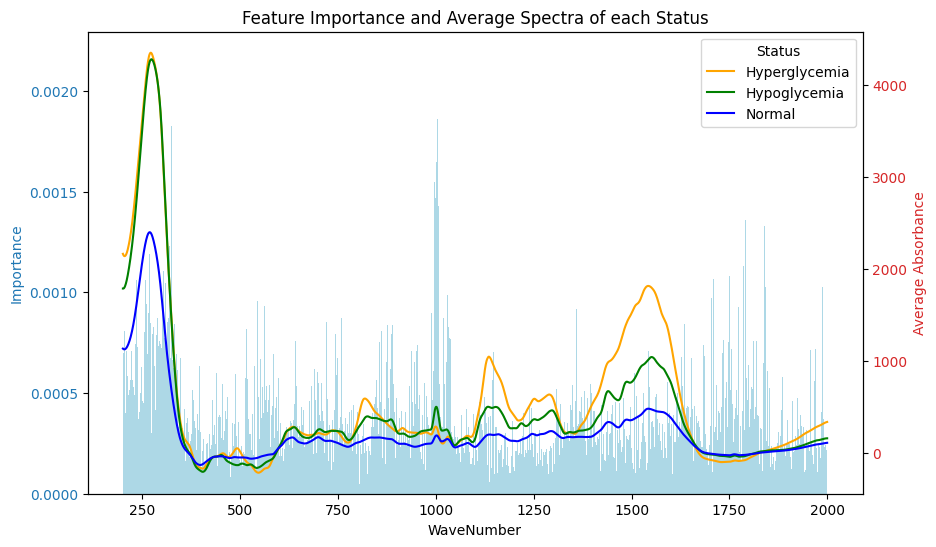

In [13]:
# Create the figure and the first (left) axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the bar plot on the first axis for Feature Importance
colors = ['lightblue'] * len(wavenumber_importance_df['WaveNumber'])
ax1.bar(wavenumber_importance_df['WaveNumber'], wavenumber_importance_df['Importance'], color=colors)
ax1.set_xlabel('WaveNumber')
ax1.set_ylabel('Importance', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create the second (right) axis, sharing the same x-axis
ax2 = ax1.twinx()

# Calculate average absorbance by WaveNumber and Status
avg_absorbance = df.groupby(['WaveNumber', 'Status'])['Absorbance'].mean().reset_index()

# Color mapping for 'Status'
color_map = {'Normal': 'blue', 'Hyperglycemia': 'orange', 'Hypoglycemia': 'green'}

# Plot average absorbance line plot on the second axis for each status
for status, group in avg_absorbance.groupby('Status'):
    ax2.plot(group['WaveNumber'], group['Absorbance'], label=status, color=color_map[status])

ax2.set_ylabel('Average Absorbance', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Adding legend for the line plots to distinguish between statuses
ax2.legend(title='Status')

# Title for the entire plot
plt.title('Feature Importance and Average Spectra of each Status')

# # Show the plot
# plt.tight_layout()
# plt.show()

#### **Cross-Val Importance**

Training the model on the whole dataset may be misleading, lets look at the average feature importance of each WaveNumber across the 10 folds.

In [14]:
from sklearn.model_selection import KFold

# Splitting the dataframe into features (X) and target variable (y)
X = wavelength_df.drop(['Status'], axis=1)
y = wavelength_df['Status']

# Creating the KFold object
cv = KFold(n_splits=10, shuffle=True, random_state=1234)

# Initialising an array to store feature importances across all folds
feature_importances = np.zeros(X.shape[1])

# Looping through each split
for train_index, test_index in cv.split(X, y):
    # Splitting the data into training and testing sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Creating and fitting the Extra Trees classifier
    et = ExtraTreesClassifier(random_state=1234)
    et.fit(X_train, y_train)
    
    # Accumulating the feature importances
    feature_importances += et.feature_importances_

# Averaging the feature importances across all folds
feature_importances /= 10

# Creating a DataFrame from the feature names and their average importance
feature_names = X.columns
wavenumber_importance_df = pd.DataFrame({
    'WaveNumber': feature_names,
    'Importance': feature_importances
})

# Optionally, you might want to sort the DataFrame based on the importances
wavenumber_importance_df = wavenumber_importance_df.sort_values(by='Importance', ascending=False)

# Displaying the DataFrame
wavenumber_importance_df

,WaveNumber,Importance
1171,1000.2278,0.002282
1173,1001.5945,0.002193
1175,1002.9613,0.001992
1177,1004.328,0.001982
1170,999.54443,0.001805
...,...,...
1792,1424.6013,0.000148
1470,1204.5558,0.000147
406,477.44876,0.000147
1473,1206.606,0.000143


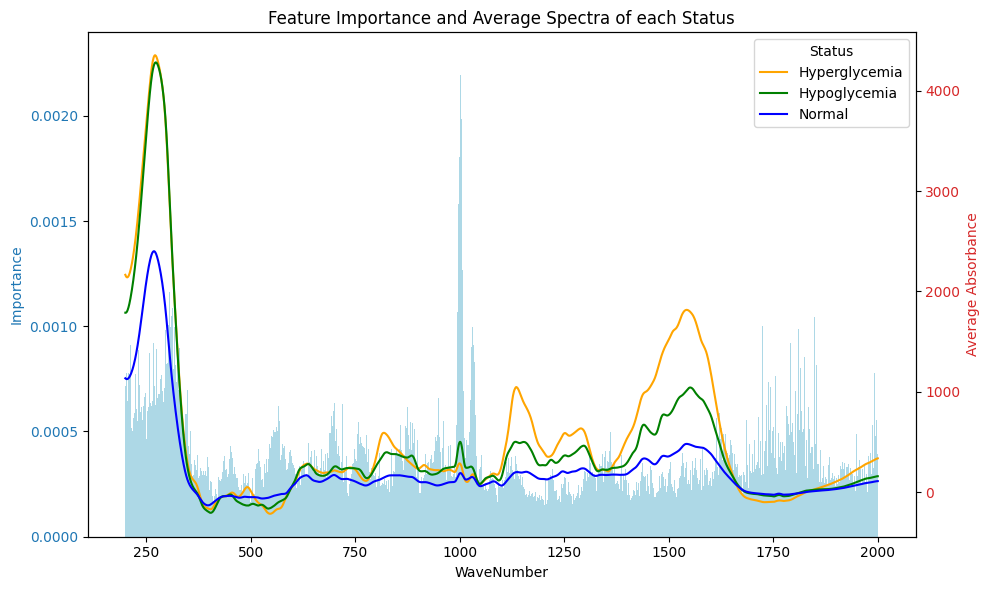

In [15]:
# Create the figure and the first (left) axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the bar plot on the first axis for Feature Importance
colors = ['lightblue'] * len(wavenumber_importance_df['WaveNumber'])
ax1.bar(wavenumber_importance_df['WaveNumber'], wavenumber_importance_df['Importance'], color=colors)
ax1.set_xlabel('WaveNumber')
ax1.set_ylabel('Importance', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create the second (right) axis, sharing the same x-axis
ax2 = ax1.twinx()

# Calculate average absorbance by WaveNumber and Status
avg_absorbance = df.groupby(['WaveNumber', 'Status'])['Absorbance'].mean().reset_index()

# Color mapping for 'Status'
color_map = {'Normal': 'blue', 'Hyperglycemia': 'orange', 'Hypoglycemia': 'green'}

# Plot average absorbance line plot on the second axis for each status
for status, group in avg_absorbance.groupby('Status'):
    ax2.plot(group['WaveNumber'], group['Absorbance'], label=status, color=color_map[status])

ax2.set_ylabel('Average Absorbance', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Adding legend for the line plots to distinguish between statuses
ax2.legend(title='Status')

# Title for the entire plot
plt.title('Feature Importance and Average Spectra of each Status')

# Show the plot
plt.tight_layout()
plt.show()